# Churn Modeling

We are going to attempt to create a predictive model that accuratly predicts churn a month in advance. This is a continuation of previous research but we are taking in the fees and the ratios of the fees. That way we can detect the change in fees in relation to the transaction frequency and amount. I'll have to develop the dataset further however the SQL query providing the dataset is descirbed below (this is an example of active merchants) 

In [1]:
#imports we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

sb.set_theme(style="white")

In [2]:
#import our data
df = pd.read_csv("../Data/merchants_summaries (2).csv", sep=';', decimal=',', index_col=None)

df.head()

,period,SettlementAmountISK,NMerchantID,MerchantName,DaysSinceLastSettlement,CompanySSN,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive
0,619,405606.0,8001896,Adalbilar,0.0,6005161320,44,0.186047,-2490.9604,-0.006141,12.0,0.825000,331161.5,-0.063492,0.0,1
1,619,2300708.0,8001997,BK Kjuklingur,0.0,5011032090,700,0.011445,-29101.9137,-0.012649,1094.0,0.011299,3608151.5,-0.023730,0.0,1
2,618,66685.0,8002023,Taeki.is,23.0,6503992859,2,11.000000,-733.6965,-0.011002,1.0,0.000000,51956.0,-0.016284,35685.0,1
3,619,18000.0,8002049,M Harstofa,0.0,4803190950,2,3.000000,-177.2200,-0.009846,13.0,0.500000,92200.0,-0.021834,145960.0,1
4,619,786198.0,8002055,Bílvirkinn bifreiðaverkstæði,0.0,5404201300,14,0.615385,-6926.5878,-0.008810,21.0,0.361111,1024643.0,-0.012945,-84345.0,1


In [3]:
df = df.drop(df[(df['MerchantActive'] == 1) & (df['period'] < 619)].index)

df = df.drop(columns=['period', 'MerchantName', 'CompanySSN', 'NMerchantID', 'DaysSinceLastSettlement'])

# Data Analysis

SettlementAmountISK: 0.07%
Transactions: 0.00%
avgTransactionsPerDay: 0.00%
Fees: 59.87%
FeeRatio: 60.10%
TransactionsLastTwoMonths: 10.58%
avgTransactionsPerDayLastTwoMonths: 10.58%
SettlementsLastTwoMonths: 10.61%
FeeRatioLastTwoMonths: 60.20%
MerchantBalance: 55.73%
MerchantActive: 0.00%


,SettlementAmountISK,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive
0,405606.0,44,0.186047,-2490.9604,-0.006141,12.0,0.825000,331161.5,-0.063492,0.0,1
1,2300708.0,700,0.011445,-29101.9137,-0.012649,1094.0,0.011299,3608151.5,-0.023730,0.0,1
3,18000.0,2,3.000000,-177.2200,-0.009846,13.0,0.500000,92200.0,-0.021834,145960.0,1
4,786198.0,14,0.615385,-6926.5878,-0.008810,21.0,0.361111,1024643.0,-0.012945,-84345.0,1
5,1275535.0,12,0.727273,-8070.7139,-0.006327,15.0,0.962963,1691123.0,-0.032122,-914.0,1


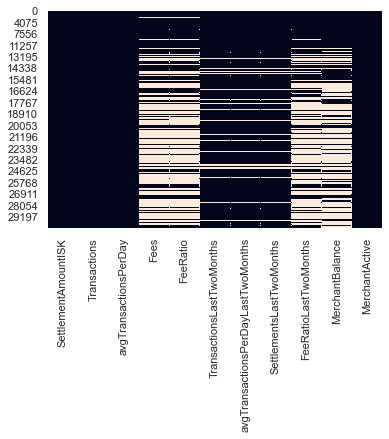

In [4]:
row_count, col_count = df.shape
for index, missingAmount in enumerate(df.isnull().sum()):
    percentage = (missingAmount / row_count)*100
    feature = df.columns[index]
    print(f"{feature}: {percentage:.2f}%")   
sb.heatmap(df.isnull(), cbar=False)

df = df.dropna() # drop rows with null

df.head()

Percantage of (1) data present: 49.96469425222426%
Percantage of (0) data present: 50.03530574777574%
Total number of rows in data:  7081


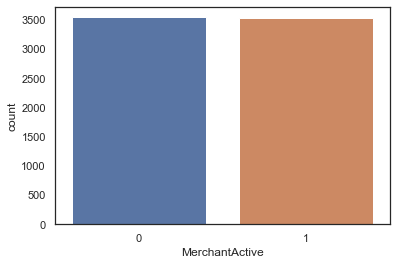

In [5]:
print("Percantage of (1) data present: {}%".format(len(df[df['MerchantActive'] == 1])/len(df['MerchantActive']) * 100))
print("Percantage of (0) data present: {}%".format(len(df[df['MerchantActive'] == 0])/len(df['MerchantActive']) * 100))
print("Total number of rows in data: ", len(df))
ax = sb.countplot(x='MerchantActive', data=df)

<AxesSubplot:>

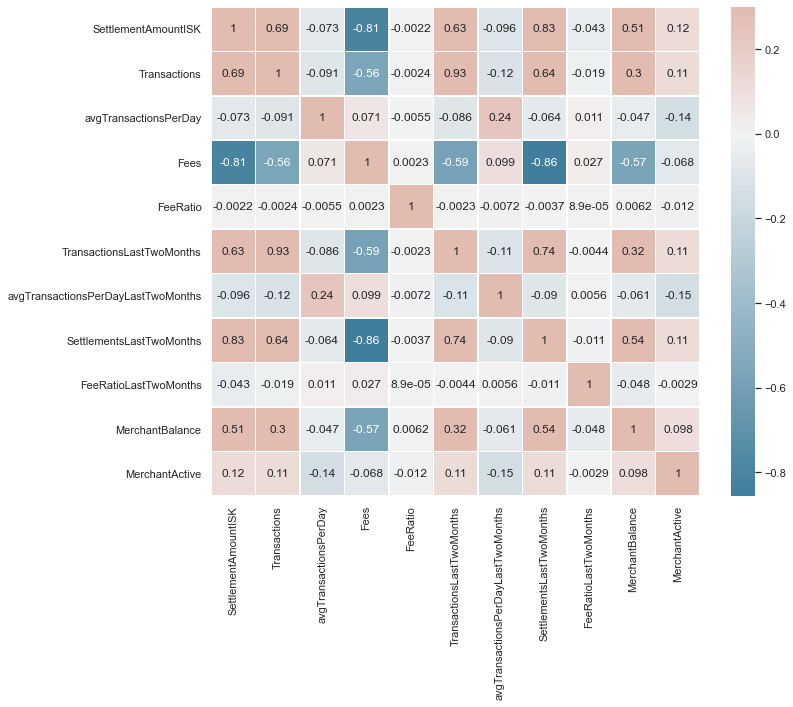

In [6]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)

As shown above, there is very little corrilation of the features we have directly linked to the MerchantActive label... sad

# Model training and testing

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier # might test with decision trees and such later
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [8]:
X = df.drop(['MerchantActive'], axis=1)
y = df['MerchantActive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [9]:
#random forest hyper parameter tuning
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [x*10 for x in range(15)]
}

clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 20.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140]},
             verbose=2)

In [10]:
clf_rf = None
clf_rf_score = 0

for i in range(100):
    c = grid_search.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_rf_score:
        print("Current best: {}".format(score))
        clf_rf_score = score
        clf_rf = c
print("Max: {}".format(clf_rf_score))

Current best: 0.8193366266760762
Current best: 0.8221594918842625
Current best: 0.8270995059985886
Max: 0.8270995059985886


### Boosted Random Forest

In [11]:
param_grid = {
    'n_estimators': [x*10 for x in range(15)],
    'learning_rate': [0.1+(x*0.1) for x in range(15)],
    'algorithm': ['SAMME', 'SAMME.R']
}

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=110))

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed: 80.6min
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed: 94.0min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 96.9min finished


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                                                max_depth=110,
                                                                                max_features=2,
                                                                                min_samples_leaf=3,
                                                                                min_samples_split=10,
                                                                                n_estimators=110)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0, 1.1, 1.2000000000000002,
                                           1.3000000000000003,
         

In [12]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada = None
clf_ada_score = 0

for i in range(100):
    c = grid_search.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_ada_score:
        print("Current best: {}".format(score))
        clf_ada_score = score
        clf_ada = c
print("Max: {}".format(clf_ada_score))

Current best: 0.8221594918842625
Current best: 0.8242766407904023
Current best: 0.8278052223006351
Current best: 0.8299223712067749
Current best: 0.8313338038108681
Max: 0.8313338038108681


### Gradient Boosting

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [x*10 for x in range(15)],
    'learning_rate': [0.1+(x*0.1) for x in range(15)],
    'subsample':[0.1*(x+1) for x in range(10)],
    'loss': ['deviance', 'exponential']
}

clf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4500 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 908 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1508 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2126 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2933 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3820 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4789 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 5838 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 7097 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 8448 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 9857 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 11498 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 13152 tasks      

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0, 1.1, 1.2000000000000002,
                                           1.3000000000000003,
                                           1.4000000000000001,
                                           1.5000000000000002],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140],
                         'subsample': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                       0.6000000000000001, 0.7000000000000001,
                                       0.8, 0.9, 1.0]},
             verbose=2)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = None
clf_gb_score = 0

for i in range(100):
    c = grid_search.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_gb_score:
        print("Current best: {}".format(score))
        clf_gb_score = score
        clf_gb = c
print("Max: {}".format(clf_gb_score))

Current best: 0.8193366266760762
Current best: 0.821453775582216
Current best: 0.8221594918842625
Current best: 0.8285109386026818
Current best: 0.8292166549047283
Max: 0.8292166549047283


### Results

Name                          Accuracy  Precision Recall    F1        
AdaBoostClassifier            82.6      79.9      85.1      82.4      
RandomForestClassifier        81.7      79.1      83.9      81.4      
GradientBoostingClassifier    82.2      80.9      83.6      82.2      


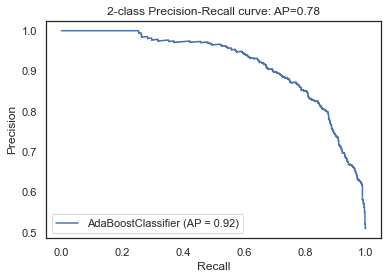

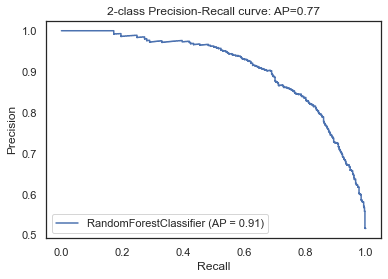

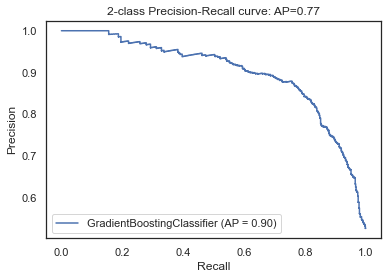

In [15]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

clfs = [clf_ada, clf_rf, clf_gb]

print("{:<30}{:<10}{:<10}{:<10}{:<10}".format("Name", "Accuracy", "Precision", "Recall", "F1"))

for c in clfs:
    y_pred = c.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)
    f1 = f1_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    
    print("{:<30}{:<10.1f}{:<10.1f}{:<10.1f}{:<10.1f}".format(c.__class__.__name__, accuracy*100, precision*100, recall*100, f1*100))

for c in clfs:
    y_pred = c.predict(X_test)
    disp = plot_precision_recall_curve(c, X_test, y_test)


    average_precision = average_precision_score(y_test, y_pred)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))

As shown above, the Adaboosted tree has a slightly better average precision than the Random forest and the GBoosted clf.

In [16]:
import pickle

#saving our classifier
with open('boosted-random-forest-17-11-2020.pkl', 'wb') as f:
    pickle.dump(clf_ada, f)

# Prediction

In [17]:
#import our data that we didn't train on
df = pd.read_csv("../Data/merchants_summaries (2).csv", sep=';', decimal=',', index_col=None)

df = df.drop(df[(df['MerchantActive'] == 1) & (df['period'] >= 618)].index) #don't do the prediction on merchants that we trained on
df = df.drop(df[(df['MerchantActive'] == 0)].index) # drop merchants that we know are inactive

df = df.dropna() #drop rows with null values
df.head()

,period,SettlementAmountISK,NMerchantID,MerchantName,DaysSinceLastSettlement,CompanySSN,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive
28,615,544000.0,9000232,Aegir 3,72.0,4412071070,33,0.437500,-7891.20,-0.014506,15.0,1.275641,210500.0,-0.063755,254710.0,1
29,602,80168.0,9000400,Hvalaskoðun Reykjavík ehf,492.0,4405004040,1,0.000000,-671.40,-0.008375,1.0,0.000000,6943.5,0.106782,837558.0,1
30,602,837558.0,9000400,Hvalaskoðun Reykjavík ehf,492.0,4405004040,2,0.000000,-6963.74,-0.008314,1.0,0.000000,36595.5,0.109400,837558.0,1
36,604,65900.0,9003886,Kirkjuvogskirkja,408.0,6901690299,35,0.029412,-288.40,-0.004376,28.0,0.013158,74350.0,-0.003586,30500.0,1
42,608,312453.0,9006677,Bílalausnir,329.0,5409150750,3,4.500000,-5799.43,-0.018561,9.0,1.008333,260716.0,-0.031949,213633.0,1


In [18]:
df_predict = df.drop(columns=['period', 'MerchantName', 'CompanySSN', 'NMerchantID', 'DaysSinceLastSettlement'])
X = df_predict.drop(['MerchantActive'], axis=1)
y_pred = [y_item[0] for y_item in clf_ada.predict_proba(X)]

df['churn_proba']=y_pred
df.head()

,period,SettlementAmountISK,NMerchantID,MerchantName,DaysSinceLastSettlement,CompanySSN,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive,churn_proba
28,615,544000.0,9000232,Aegir 3,72.0,4412071070,33,0.437500,-7891.20,-0.014506,15.0,1.275641,210500.0,-0.063755,254710.0,1,0.586032
29,602,80168.0,9000400,Hvalaskoðun Reykjavík ehf,492.0,4405004040,1,0.000000,-671.40,-0.008375,1.0,0.000000,6943.5,0.106782,837558.0,1,0.800810
30,602,837558.0,9000400,Hvalaskoðun Reykjavík ehf,492.0,4405004040,2,0.000000,-6963.74,-0.008314,1.0,0.000000,36595.5,0.109400,837558.0,1,0.705736
36,604,65900.0,9003886,Kirkjuvogskirkja,408.0,6901690299,35,0.029412,-288.40,-0.004376,28.0,0.013158,74350.0,-0.003586,30500.0,1,0.935720
42,608,312453.0,9006677,Bílalausnir,329.0,5409150750,3,4.500000,-5799.43,-0.018561,9.0,1.008333,260716.0,-0.031949,213633.0,1,0.430220


In [19]:
df.to_csv("predictions(17-11-2020).csv")

# Modal Output Analysis 

Mean days since last settlement: 245.98
Number of merchants in the set: 4613


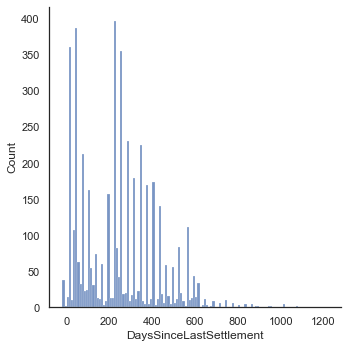

In [20]:
#Distribution days since last trx of all merchants
sb.displot(df, x="DaysSinceLastSettlement", binwidth=10)
print(f"Mean days since last settlement: {round(df['DaysSinceLastSettlement'].mean(),2)}")
print(f"Number of merchants in the set: {len(df)}")

Mean days since last settlement: 261.29
Number of merchants in the set: 1931


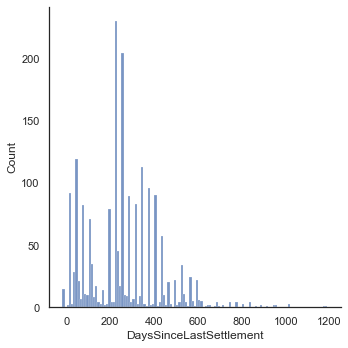

In [21]:
#Same distribution merchants that have a chrun prediction above 70%
sb.displot(df[df['churn_proba'] > 0.7], x="DaysSinceLastSettlement", binwidth=10)
print(f"Mean days since last settlement: {round(df[df['churn_proba'] > 0.7]['DaysSinceLastSettlement'].mean(),2)}")
print(f"Number of merchants in the set: {len(df[df['churn_proba'] > 0.7])}")

Mean days since last settlement: 280.66
Number of merchants in the set: 1055


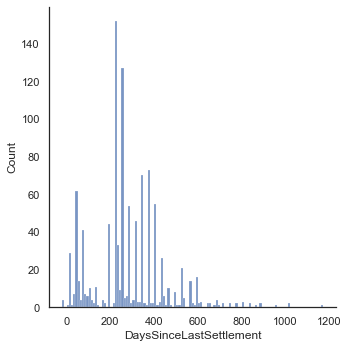

In [22]:
#Same distribution merchants that have a chrun prediction above 70%
sb.displot(df[df['churn_proba'] > 0.8], x="DaysSinceLastSettlement", binwidth=10)
print(f"Mean days since last settlement: {round(df[df['churn_proba'] > 0.8]['DaysSinceLastSettlement'].mean(),2)}")
print(f"Number of merchants in the set: {len(df[df['churn_proba'] > 0.8])}")

Mean days since last settlement: 294.32
Number of merchants in the set: 284


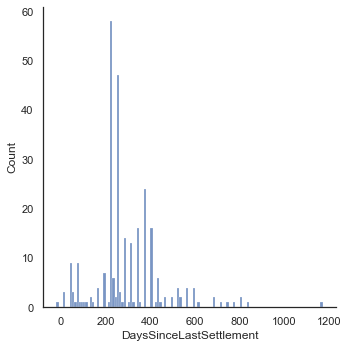

In [23]:
#Same distribution merchants that have a chrun prediction above 70%
sb.displot(df[df['churn_proba'] > 0.9], x="DaysSinceLastSettlement", binwidth=10)
print(f"Mean days since last settlement: {round(df[df['churn_proba'] > 0.9]['DaysSinceLastSettlement'].mean(),2)}")
print(f"Number of merchants in the set: {len(df[df['churn_proba'] > 0.9])}")